# 파일 얻기

In [1]:
pwd

'/Users/dizwe/programm/maetel/maetel_snore_detect/Beeeep--'

In [3]:
%cd data

/Users/dizwe/programm/maetel/maetel_snore_detect/Beeeep--/data


In [2]:
#zip file을 내 드라이브에 다운받아야함
# !mkdir ./beep_data
# !unzip XY_train.zip -d ./beep_data
# !unzip XY_test.zip -d ./beep_data

# Data Check

In [4]:
n_freq = 128  # 스펙트로그램 높이

# Data Loader
- with Keras

In [5]:
import tensorflow

In [6]:
import os 
import pandas as pd
import numpy as np
from keras.utils import Sequence 

Using TensorFlow backend.


#### train,validation data 만들기

In [10]:
data_dir = os.path.join('.', 'XY_train')
x_s = []
y_s = []
for file in os.listdir(data_dir):
    if file.startswith('x_'):
        x_s.append(os.path.join(data_dir,file))
    elif file.startswith('y_'):
        y_s.append(os.path.join(data_dir,file))
    x_s = sorted(x_s)
    y_s = sorted(y_s)
df = pd.DataFrame({'x':x_s, 'y':y_s})
df.head()

,x,y
0,./XY_train/x_0.npy,./XY_train/y_0.npy
1,./XY_train/x_1.npy,./XY_train/y_1.npy
2,./XY_train/x_10.npy,./XY_train/y_10.npy
3,./XY_train/x_100.npy,./XY_train/y_100.npy
4,./XY_train/x_1000.npy,./XY_train/y_1000.npy


In [0]:
# 사이즈가 안맞아서 체크했었음 -> padidng해서 채워넣기
# # np.load(df.x[0]).shape, df.y
# for one_x, one_y in zip(df.x, df.y):
#     if np.load(one_x).shape!=(862, 128) or np.load(one_y).shape!=(212, 1):
#       print(one_x, one_y)
#       print(np.load(one_x).shape, np.load(one_y).shape)
    

In [9]:
# Train과 Valid로 나누기(Test말고) 섞어서 데이터 떼내기
train_ratio = 0.8
idxs = list(range(len(df)))
np.random.shuffle(idxs)
train_idx = idxs[:int(len(df)*train_ratio)]
valid_idx = idxs[int(len(df)*train_ratio):]

train_df = df.loc[train_idx]
valid_df = df.loc[valid_idx]

print(train_df.shape, valid_df.shape)

(1600, 2) (400, 2)


### test dataset 만들기

In [12]:
data_dir = os.path.join('.', 'XY_test')
x_s = []
y_s = []
for file in os.listdir(data_dir):
    if file.startswith('x_'):
        x_s.append(os.path.join(data_dir,file))
    elif file.startswith('y_'):
        y_s.append(os.path.join(data_dir,file))
    x_s = sorted(x_s)
    y_s = sorted(y_s)
test_df = pd.DataFrame({'x':x_s, 'y':y_s})
test_df.head()

,x,y
0,./XY_test/x_0.npy,./XY_test/y_0.npy
1,./XY_test/x_1.npy,./XY_test/y_1.npy
2,./XY_test/x_10.npy,./XY_test/y_10.npy
3,./XY_test/x_100.npy,./XY_test/y_100.npy
4,./XY_test/x_101.npy,./XY_test/y_101.npy


In [0]:
class DataGenerator(Sequence):
    def __init__(self, df, batch_size, shuffle = True, valid=False):
        self.X = list(df.x)
        self.y = list(df.y)
        self.batch_size = batch_size
        self.shuffle = shuffle
        # on_epoch_end는 제일 처음과 끝에 실행됨.
        self.on_epoch_end() # 제일 처음에 실행되게 하기 위해서
    
    # shuffle을 통하여 각 batch마다 identical한 데이터셋을 학습시키는 것을 방지하여 모델을 좀 더 robust하게 만든다.
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.X))
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        # batch가 한 단위로 볼수 있는 총 수
        return int(np.floor(len(self.X) / self.batch_size))
    
    # batch를 생성한다.
    #  X, keras.utils.to_categorical(y, num_classes=self.n_classes)를 통해 6개 class이면   [0 0 1 0 0 0] 처럼 변환 가능.
    def __data_generation(self, X_list, y_list):
        X = []
        y = []
        
        for i, (img, label) in enumerate(zip(X_list, y_list)):
            np_img = np.load(img)
            np_label = np.load(label)
            if np_img.shape!=(862, 128):
              np_img = np.pad(np_img,((0,862-np_img.shape[0]),(0,0)),mode='constant',constant_values= 0)
              # print(np_img.shape,np_label.shape)
            if np_label.shape!=(212, 1):
              np_label = np.pad(np_label,((0,212-np_label.shape[0]),(0,0)),mode='constant',constant_values= 0)
              # print(np_img.shape,np_label.shape)
            X.append(np_img)
            y.append(np_label)
        
        # batch size 만큼 있던거 stack하기
        # for i in range(len(X)):
        #   print(X[i].shape,y[i].shape)
        X = np.stack(X, axis=0)
        y = np.stack(y, axis=0)

        return X, y
        
    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        X_list = [self.X[k] for k in indexes]
        y_list = [self.y[k] for k in indexes]
        # print(X_list, y_list)
        X, y = self.__data_generation(X_list, y_list)
        return X, y

In [0]:
train_generator = DataGenerator(train_df, 5)
valid_generator = DataGenerator(valid_df, 5, valid=True)
test_generator = DataGenerator(test_df, 3)

# Train

In [0]:
from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D, multiply
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam

In [0]:
# def make_model(input_shape):
    
#     X_input = Input(shape = input_shape)
#     X = Conv1D(196, kernel_size=15, strides=4)(X_input)         # CONV1D
#     X = BatchNormalization()(X)                                 # Batch normalization
#     X = Activation('relu')(X)                                   # ReLu activation
#     X = Dropout(0.2)(X)                                         # dropout (use 0.8)

#     X = GRU(units = 128, return_sequences = True)(X)            # GRU (use 128 units and return the sequences)
#     X = Dropout(0.2)(X)                                         # dropout (use 0.8)
#     X = BatchNormalization()(X)                                 # Batch normalization

#     X = GRU(units = 128, return_sequences = True)(X)            # GRU (use 128 units and return the sequences)
#     X = Dropout(0.2)(X)                                         # dropout (use 0.8)
#     X = BatchNormalization()(X)                                 # Batch normalization
#     X = Dropout(0.2)(X)                                         # dropout (use 0.8)

#     X = TimeDistributed(Dense(1, activation = "sigmoid"))(X)    # time distributed  (sigmoid)

#     model = Model(inputs = X_input, outputs = X)
#     return model

In [0]:
def make_model(input_shape):
    X_input = Input(shape = input_shape)
    # 196 아웃풋 공간
    X = Conv1D(196, kernel_size=15, strides=4)(X_input)         # CONV1D
    X = BatchNormalization()(X)                                 # Batch normalization
    X = Activation('relu')(X)                                   # ReLu activation
    X = Dropout(0.2)(X)                                         # dropout (use 0.8)

    X = GRU(units = 128, return_sequences = True)(X)            # GRU (use 128 units and return the sequences)
    X = Dropout(0.2)(X)                                         # dropout (use 0.8)
    X = BatchNormalization()(X) # Batch normalization
    y = Activation("softmax")(X)
    X = multiply([y, X])
    

    X = GRU(units = 128, return_sequences = True)(X)            # GRU (use 128 units and return the sequences)
    X = Dropout(0.2)(X)                                         # dropout (use 0.8)
    X = BatchNormalization()(X) 
    y = Activation("softmax")(X)
    X = multiply([y, X])
    X = Dropout(0.2)(X)                                         # dropout (use 0.8)

    X = TimeDistributed(Dense(1, activation = "sigmoid"))(X)    # time distributed  (sigmoid)

    model = Model(inputs = X_input, outputs = X)
    return model  

In [16]:
model = make_model(input_shape = (None, n_freq))





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [17]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, None, 128)    0                                            
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, None, 196)    376516      input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, 196)    784         conv1d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, None, 196)    0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
from keras import backend as K
import tensorflow as tf
def auc(y_true, y_pred):
    auc = tf.metrics.auc(y_true, y_pred)[1]
    K.get_session().run(tf.local_variables_initializer())
    return auc

In [19]:
# learing rate 100배 더 늘림
# beta는 adam에서 적용하는 값들이지!(모멘텀, 스텝 사이즈)
# decay : 업데이트마다 적용되는 학습률의 감소율입니다.
opt = Adam(lr=0.005, beta_1=0.9, beta_2=0.999, decay=0.01)
model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy", auc])



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.








In [20]:
train_df.iloc[0,:]       

x    ./beep_data/XY_train/x_1502.npy
y    ./beep_data/XY_train/y_1502.npy
Name: 561, dtype: object

In [0]:
model.fit_generator(generator=train_generator,
                    validation_data=valid_generator,
                    epochs = 25)  



Epoch 1/25
 36/320 [==>...........................] - ETA: 21:48 - loss: 0.6643 - acc: 0.6709 - auc: 0.5106

In [0]:
# http://www.kwangsiklee.com/2019/03/keras에서-모델-saveload하기/
model_json = model.to_json()
with open("model.json", "w") as json_file : 
    json_file.write(model_json)

model.save_weights("model.h5")
print("Saved model to disk")

In [0]:
from keras.models import model_from_json 
json_file = open("model.json", "r")
loaded_model_json = json_file.read() 
json_file.close()
loaded_model = model_from_json(loaded_model_json)

In [0]:
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

In [0]:
loaded_model.compile(loss='binary_crossentropy', optimizer=opt, metrics=["accuracy"])

In [0]:
loaded_model.fit_generator(generator=train_generator,
                    validation_data=valid_generator,
                    epochs = 2)

# Test

In [0]:
def postprocessing(outputs, th):
    for output in outputs:
        output[output<th] = 0
        output[output>=th] = 1
    return outputs

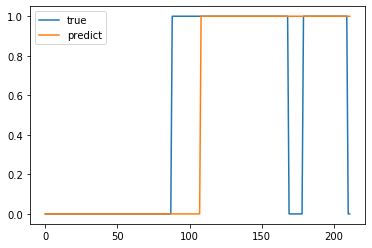

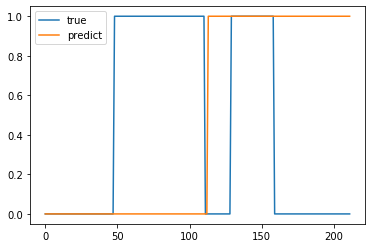

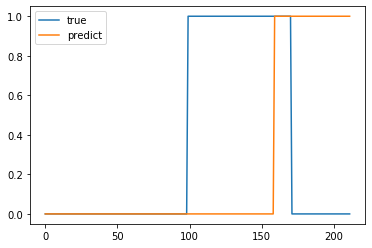

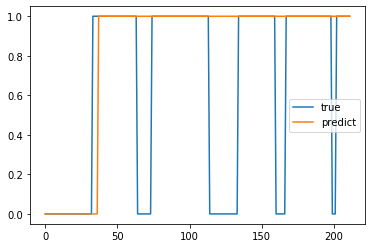

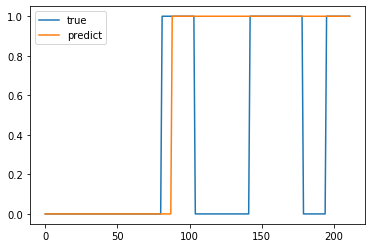

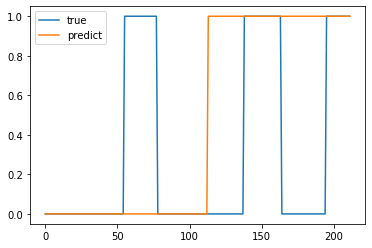

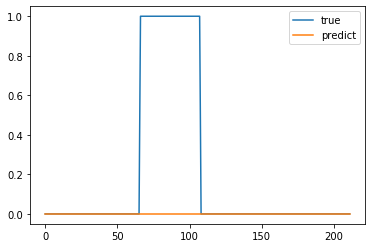

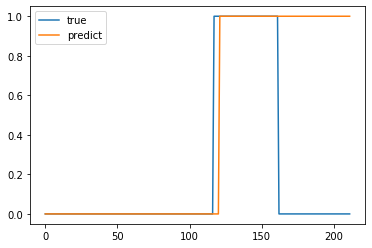

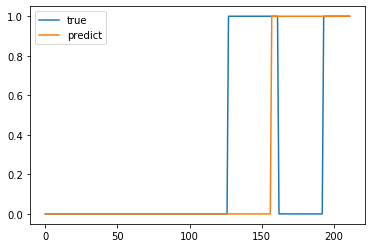

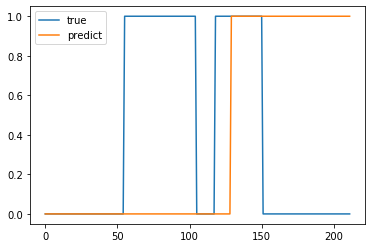

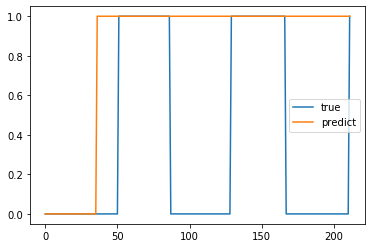

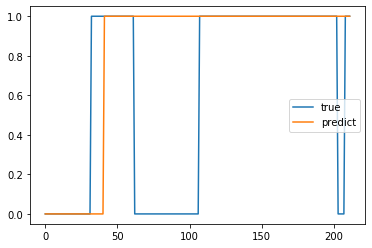

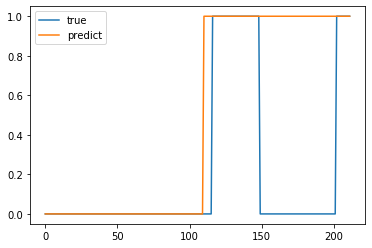

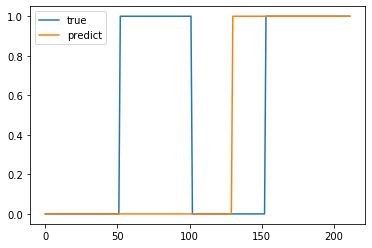

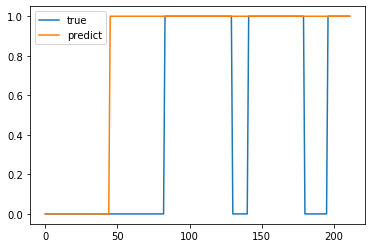

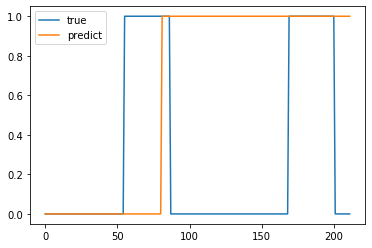

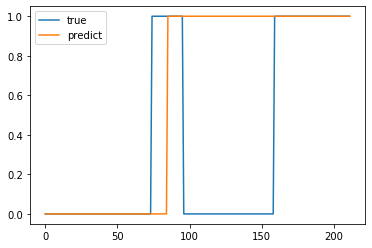

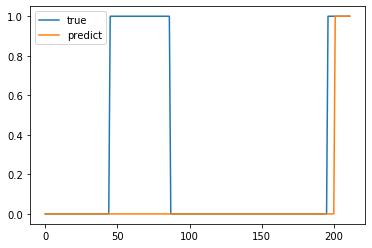

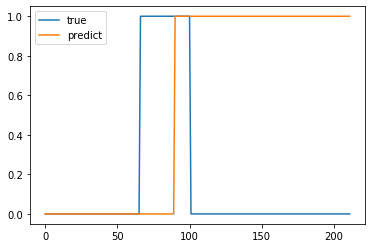

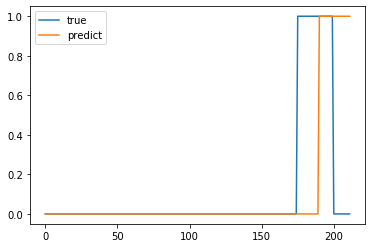

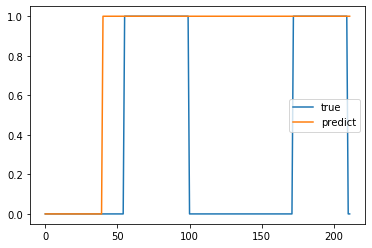

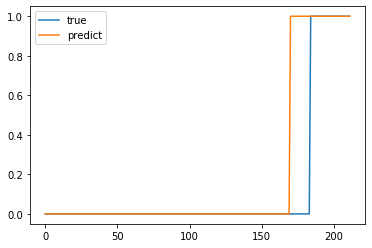

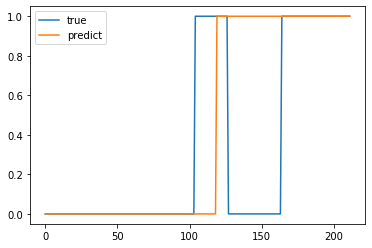

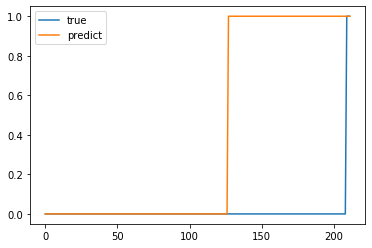

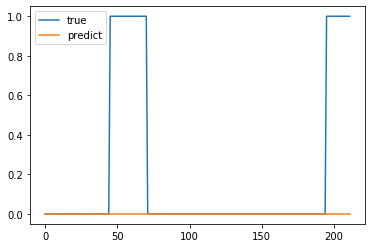

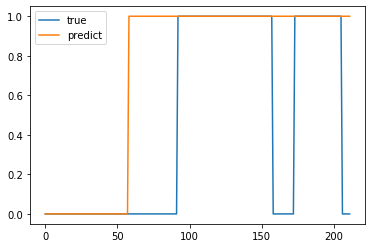

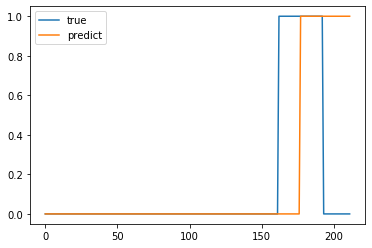

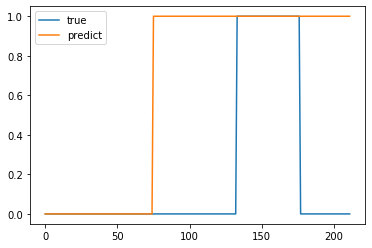

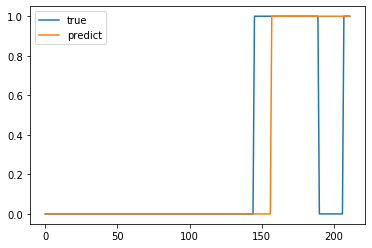

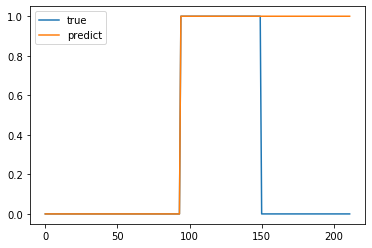

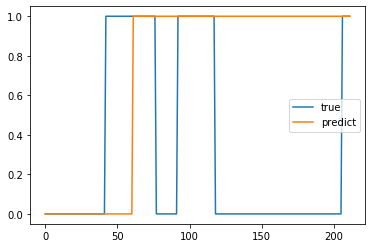

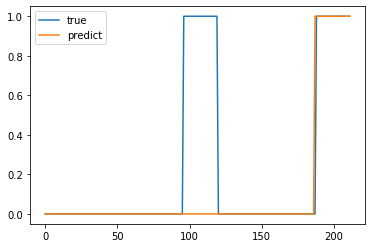

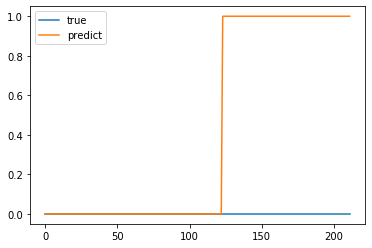

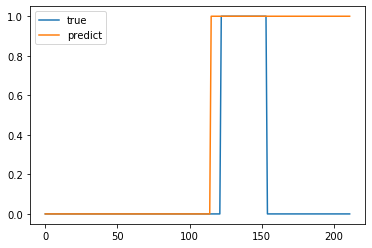

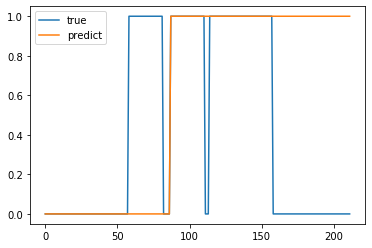

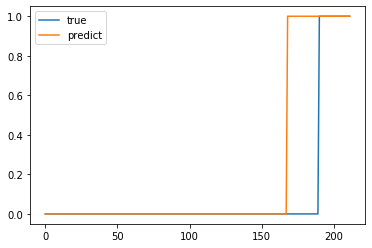

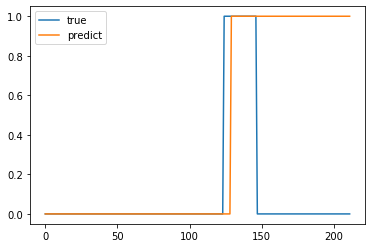

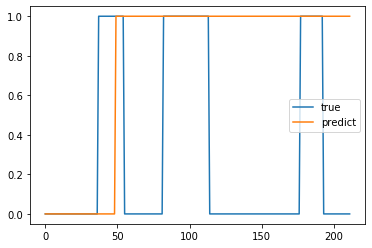

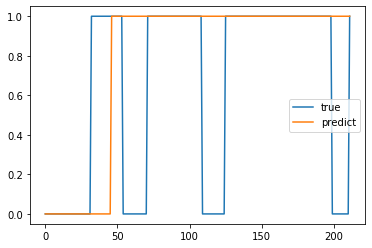

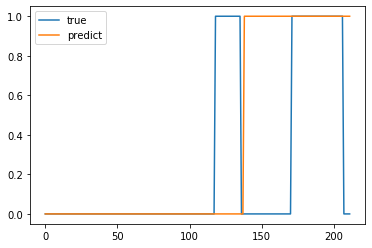

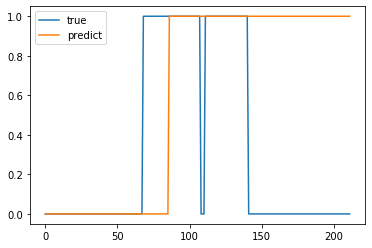

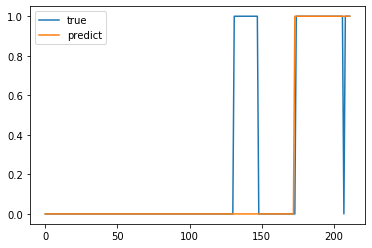

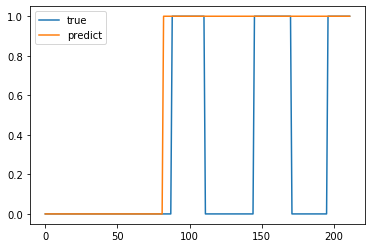

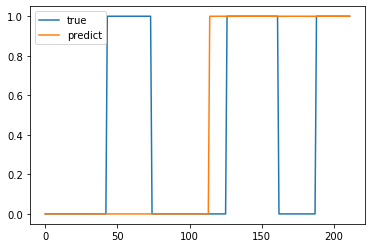

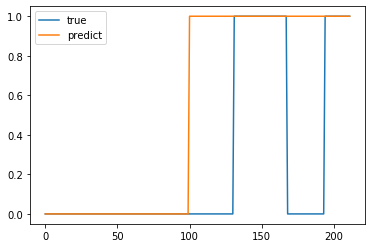

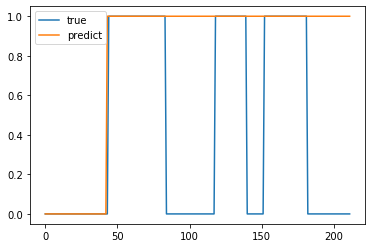

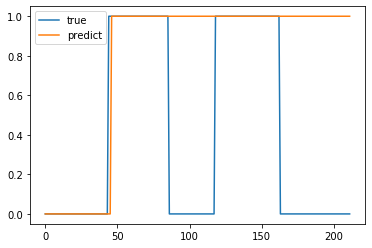

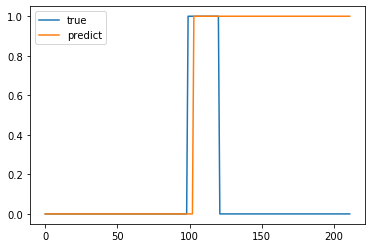

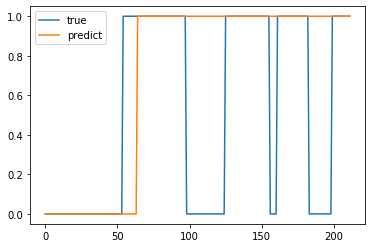

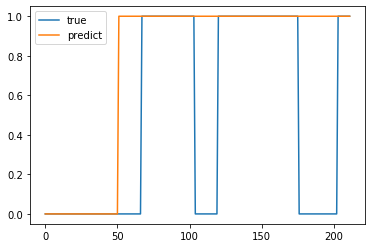

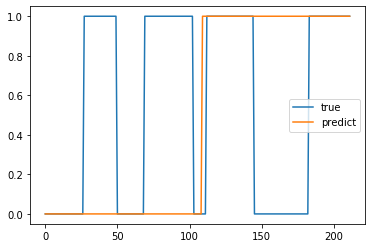

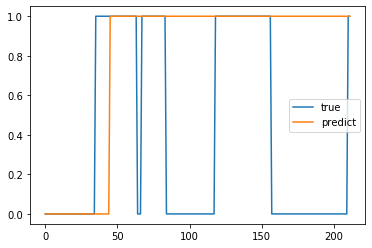

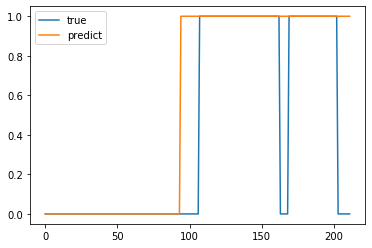

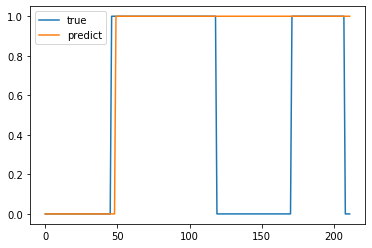

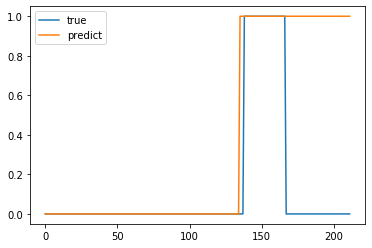

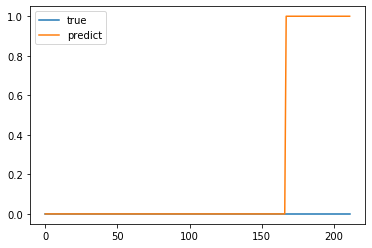

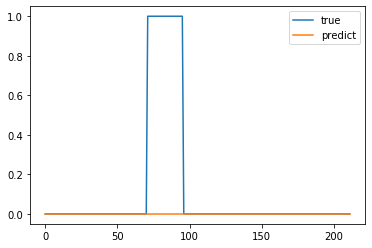

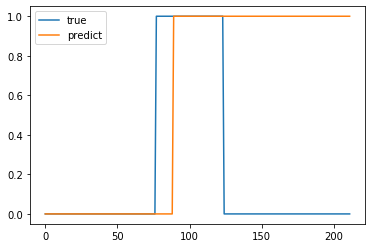

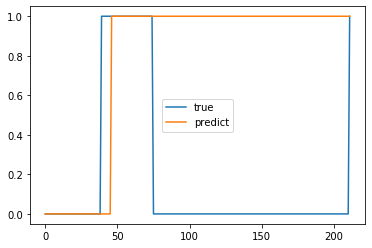

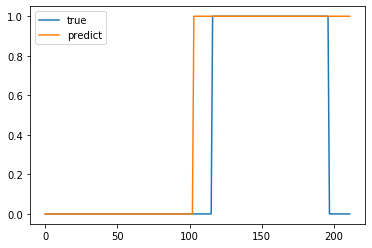

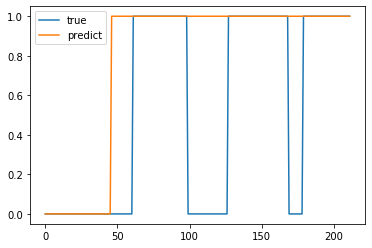

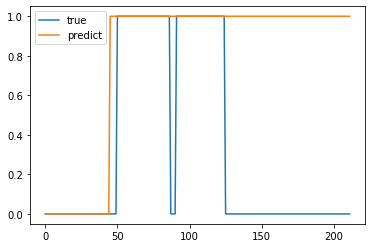

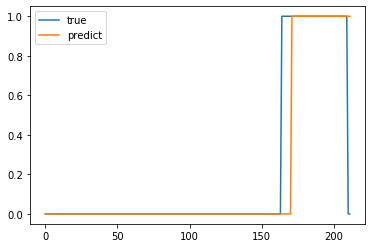

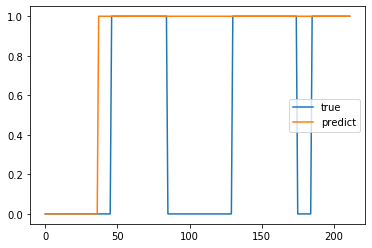

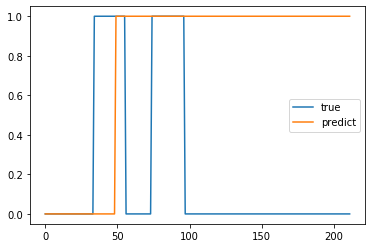

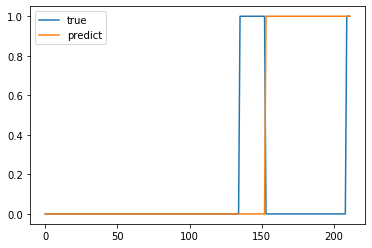

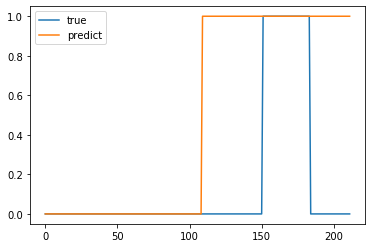

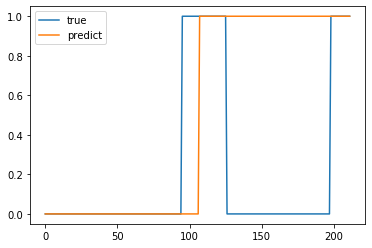

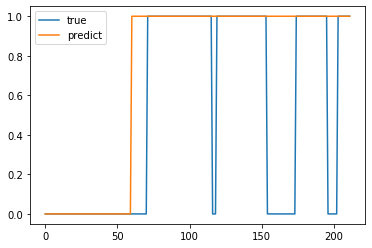

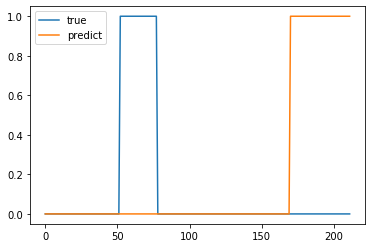

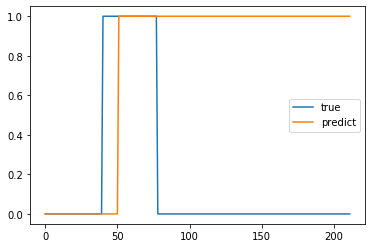

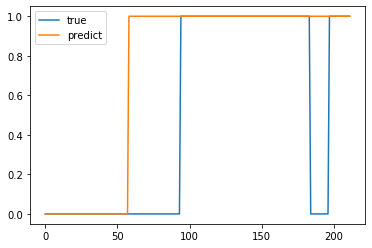

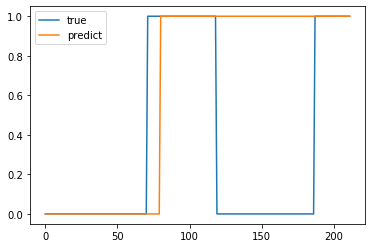

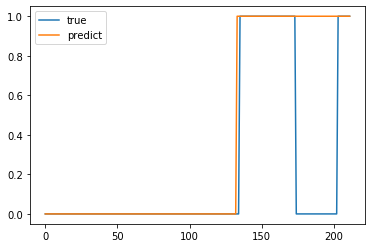

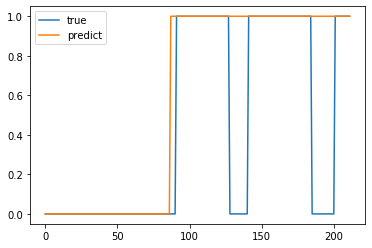

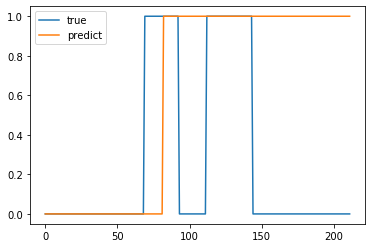

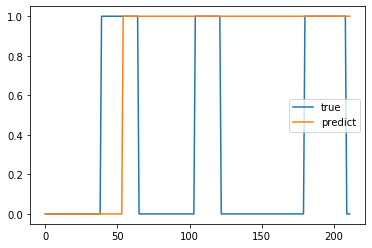

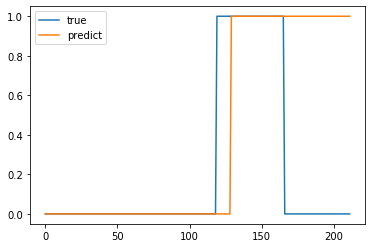

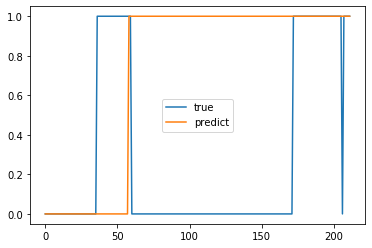

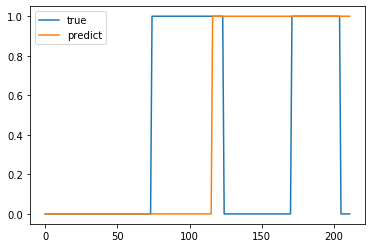

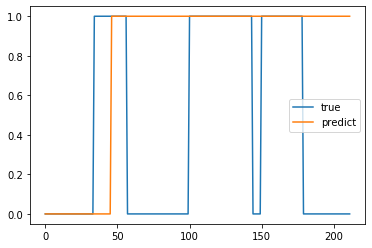

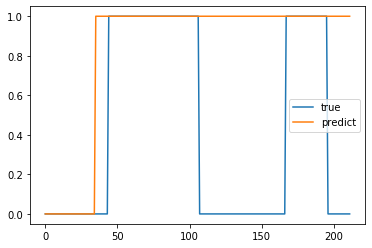

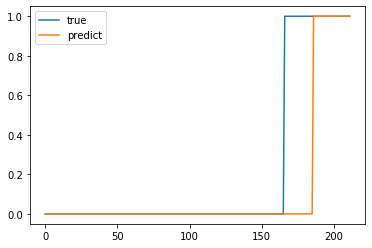

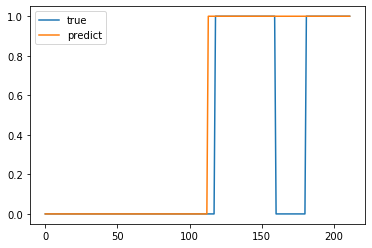

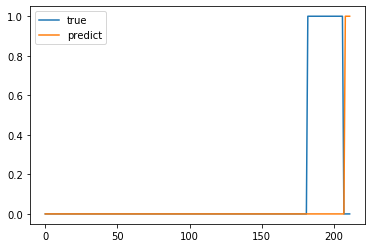

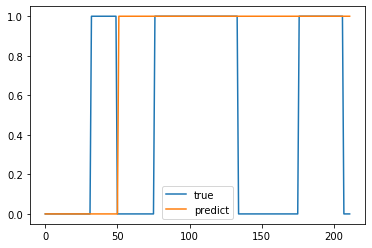

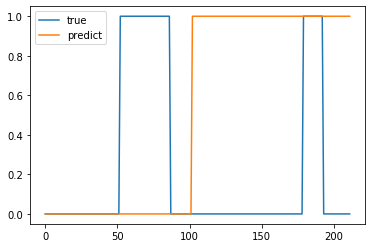

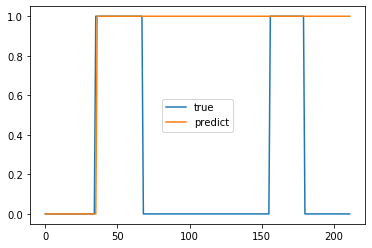

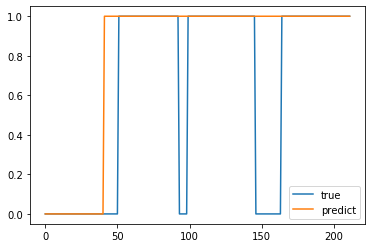

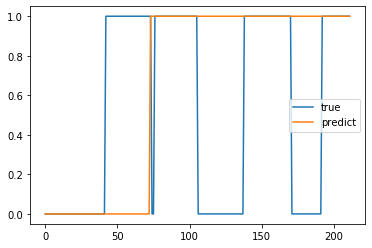

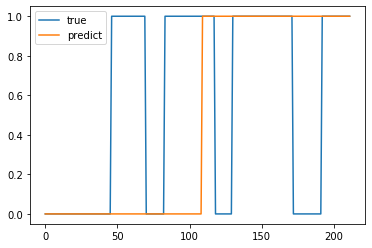

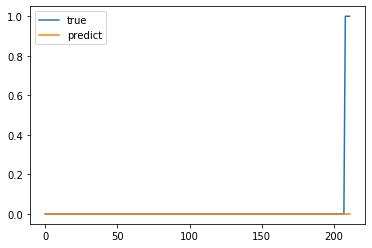

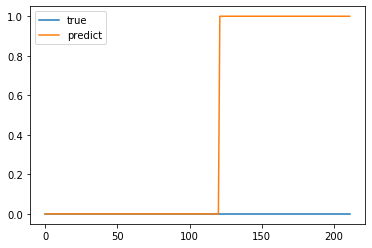

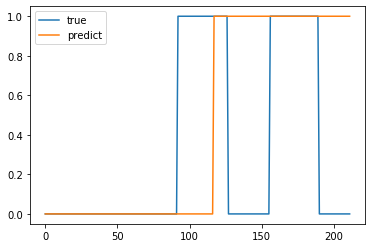

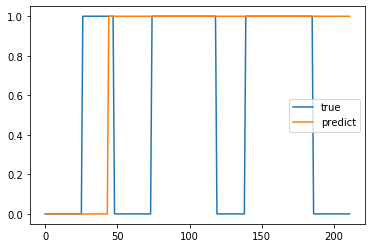

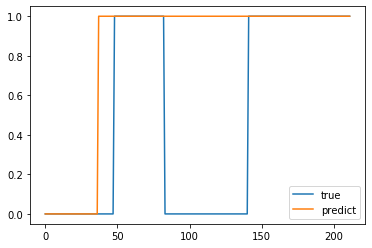

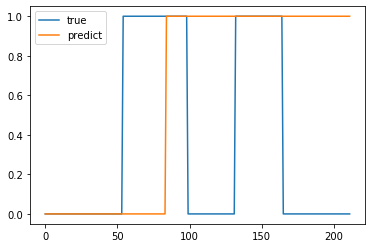

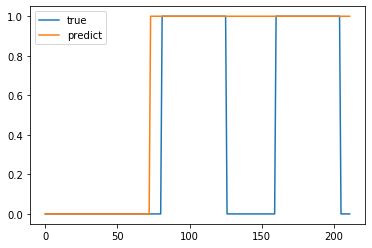

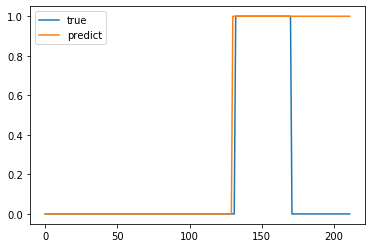

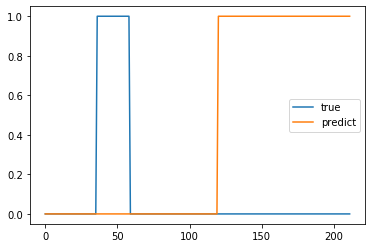

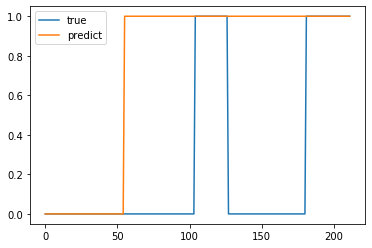

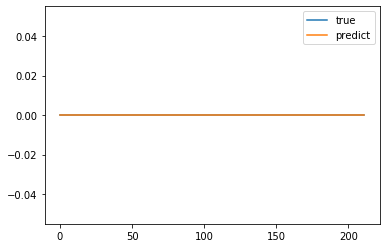

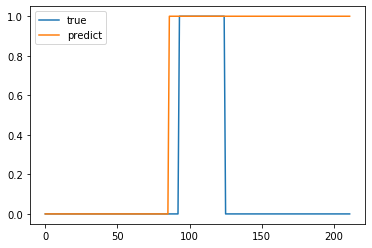

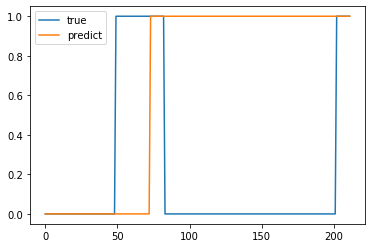

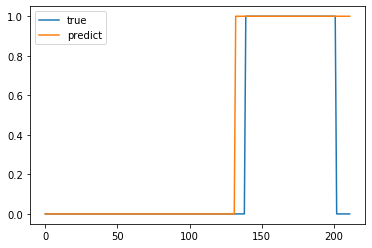

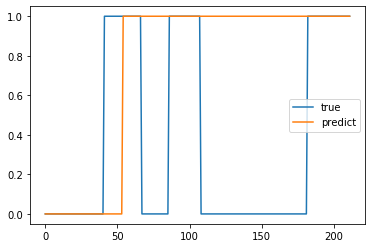

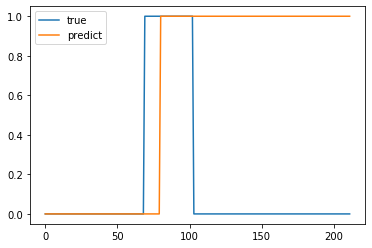

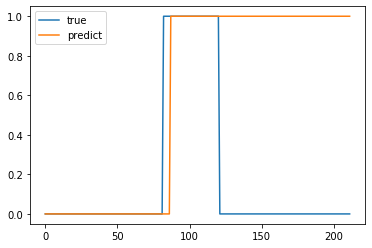

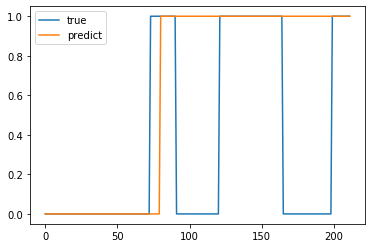

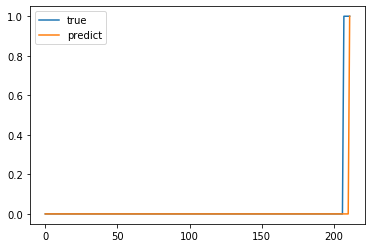

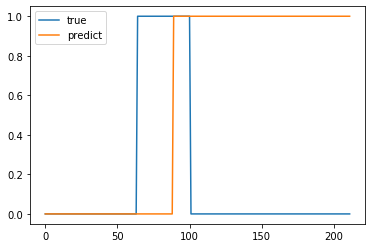

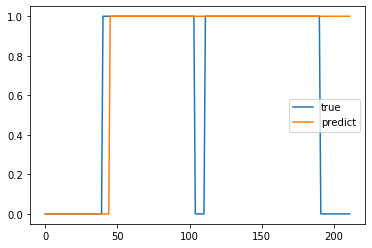

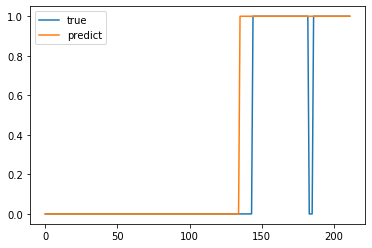

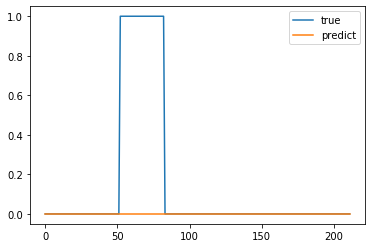

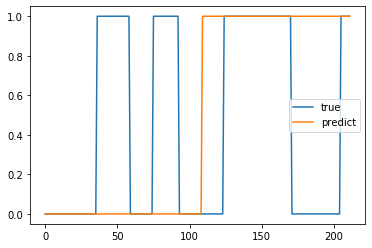

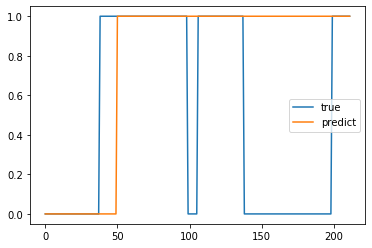

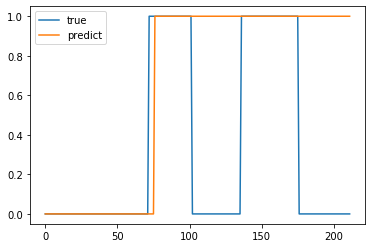

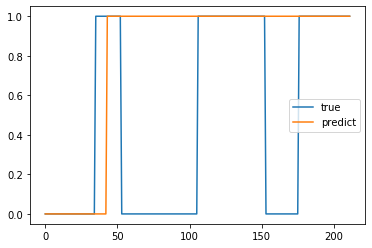

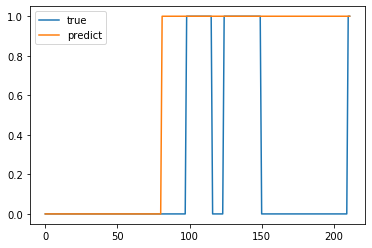

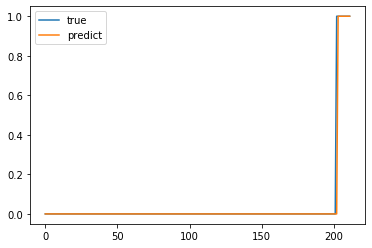

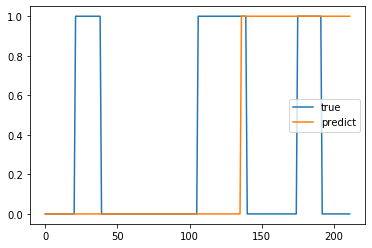

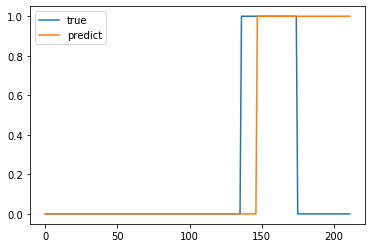

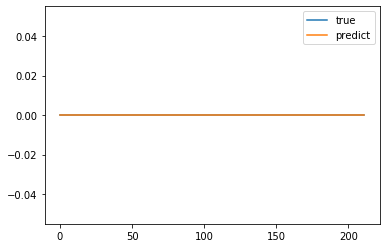

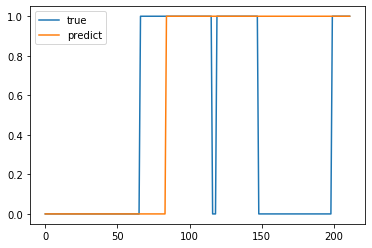

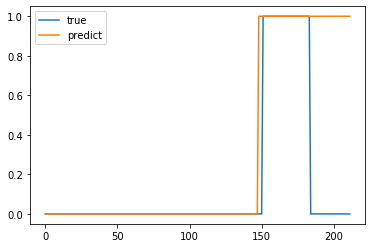

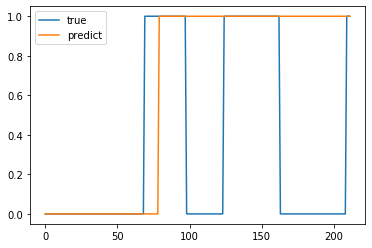

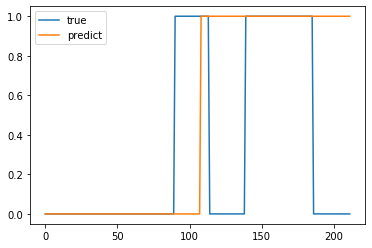

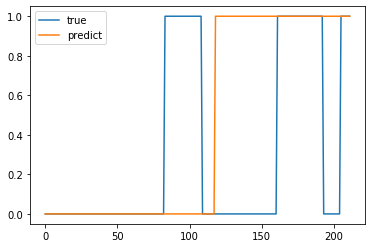

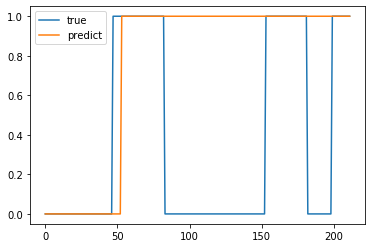

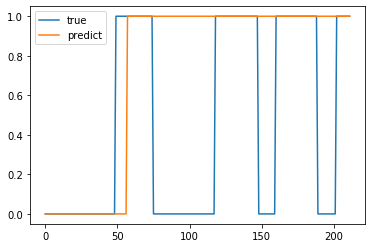

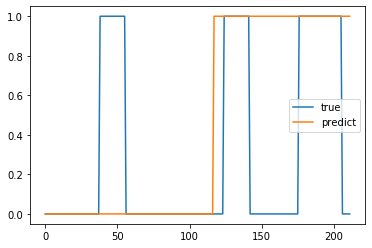

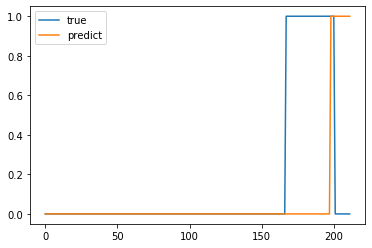

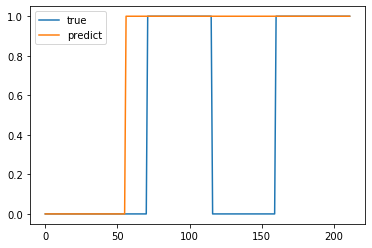

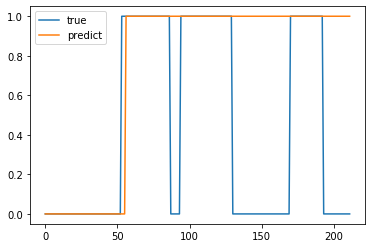

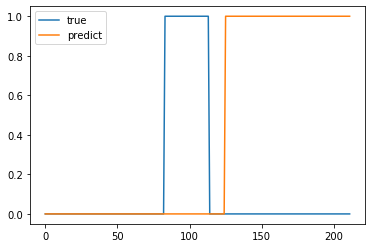

KeyboardInterrupt: ignored

In [0]:
import matplotlib.pyplot as plt
for batch in test_generator:
    x, y = batch
    output = model.predict(x)
    output = postprocessing(output,0.6)
    for i in range(len(y)):
        plt.plot(y[i], label='true')
        plt.plot(output[i], label='predict')
        plt.legend()
        plt.show()